# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Section 1:Business Understaning

The starbucks data give a situation about Sale Promotion with cupon. It give the customers a discount of BOGO(buy one get one free), which will prompt the sale if the customer use it. Customer get discount, starbuck get sale promotion and build customer potential consumption pattern.

Offers is a sales promotion strategy, which will increase the cost by instinct. For maximize the effort, we would like to find out a better way for offer delivery:
1. Does offers change customer behavior?
2. Does the change of customer behavior make more profit?

Final Goal:
1. Can we find a way to control the cost of offers, or get more profit from offers?

# Section 2:Data Understaning

## 1. Gather

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import json
import re
import math
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
%matplotlib inline

# Gaather Data#
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
print(profile.info())
profile.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB
None


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [3]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [4]:
print(transcript.info())
transcript.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB
None


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [5]:
print(portfolio.info())
portfolio.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes
None


,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


## 2. Cleaning

### 2.1 Cleaning "profile"

1. There are a lot of customers at age 118.Those are the people who do not want to give the age informations. We will consider that as a NaN.
2. "id" in profile is a hashtag, we will replace it with numbers for clearity.

In [6]:
def create_user_id_map(data=profile):
    """
    Create a map for hashed 'person' in profile to simplify the data
    Parameters
    -------
    data : the profile dataframe
    Returns
    ---------
    user_id_map: The map DataFrame between hashed person informations and
    interger numbers
    """
    user_id_map = pd.DataFrame(
        {'person': data['id'],
         'person_id': range(len(data['id']))}
    )
    return user_id_map


user_id_map = create_user_id_map()


def clean_profile_(data=profile, user_id_map=user_id_map):
    """
    Clean the profile dataframe.
    1. if the ages are above 117, treat this as Nan
    2. replace hashed 'person' into 'person_id'
    Parameters
    ------
    data : The profile dataframe.
    user_id_map : The dataframe contains the relations between hashed 'person' and 'person_id'
    Returns
    -------
    profile_new : The cleaned version of profile
    """
    profile_new = data.merge(user_id_map, how='left', left_on='id', right_on='person')
    profile_new.drop(['id', 'person'], axis=1, inplace=True)
    profile_new.loc[profile_new['age'] >= 117, 'age'] = np.nan
    # profile_new['income']  = np.log10(profile_new['income'])
    profile_new['became_member_on'] = pd.to_datetime(data['became_member_on'], format='%Y%m%d')
    return profile_new


clean_profile = clean_profile_()
%store clean_profile
clean_profile.head()

Stored 'clean_profile' (DataFrame)


,gender,age,became_member_on,income,person_id
0,None,NaN,2017-02-12,NaN,0
1,F,55.0,2017-07-15,112000.0,1
2,None,NaN,2018-07-12,NaN,2
3,F,75.0,2017-05-09,100000.0,3
4,None,NaN,2017-08-04,NaN,4


### 2.2 Cleaning "portfolio". 

1. Replace id with offer_id base on id mapping table.
2. Split channels into columns.

In [7]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [8]:
# map dict for hashed offer id 
map_dict = {'offer_id': ['BOGO_r10_d10_u7',
                         'BOGO_r10_d10_u5',
                         'INFO_u4',
                         'BOGO_r5_d5_u7',
                         'DIS_r5_d20_u10',
                         'DIS_r3_d7_u7',
                         'DIS_r2_d10_u10',
                         'INFO_u3',
                         'BOGO_r5_d5_u5',
                         'DIS_r2_d10_u7']}
offer_id_map = pd.DataFrame(map_dict)
offer_id_map = offer_id_map.merge(portfolio.loc[:, 'id'], left_index=True, right_index=True)
offer_id_map.rename(columns={'id': 'portfolio_id'}, inplace=True)
offer_id_map

,offer_id,portfolio_id
0,BOGO_r10_d10_u7,ae264e3637204a6fb9bb56bc8210ddfd
1,BOGO_r10_d10_u5,4d5c57ea9a6940dd891ad53e9dbe8da0
2,INFO_u4,3f207df678b143eea3cee63160fa8bed
3,BOGO_r5_d5_u7,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,DIS_r5_d20_u10,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,DIS_r3_d7_u7,2298d6c36e964ae4a3e7e9706d1fb8c2
6,DIS_r2_d10_u10,fafdcd668e3743c1bb461111dcafc2a4
7,INFO_u3,5a8bc65990b245e5a138643cd4eb9837
8,BOGO_r5_d5_u5,f19421c1d4aa40978ebb69ca19b0e20d
9,DIS_r2_d10_u7,2906b810c7d4411798c6938adc9daaa5


In [9]:
def clean_portfolio(portfolio=portfolio, offer_id_map=offer_id_map):
    """
    clean the portfolio data, change hashed "ID" into "offer_id" according to offer_id_map
    split channels into columns
    Parameters
    -----
    portfolio : The original profile dataframe
    offer_id_map : The dataFrame map between hased 'id' and more readable 'offer_id'.
    Returns
    -----
    port_clean : the cleaned version of profile
    """
    port_clean = portfolio.copy()
    channel_list = []
    for channel in portfolio['channels']:
        channel_list.extend(channel)
    channel_set = set(channel_list)
    
    # convert channels into dummies
    for channel in channel_set:
        port_clean['channel_' + channel] = port_clean['channels'].apply(lambda x: 1 if  x.count(channel)>0 else 0)
        
    # change id according to offer_id_map
    
    port_clean = port_clean.merge(offer_id_map, left_on= 'id', right_on = 'portfolio_id')
        
    
    port_clean.drop(['channels','id', 'portfolio_id'], axis = 1, inplace = True)
    return port_clean


portfolio_clean = clean_portfolio()
%store portfolio_clean

Stored 'portfolio_clean' (DataFrame)


In [10]:
portfolio_clean

,reward,difficulty,duration,offer_type,channel_email,channel_mobile,channel_social,channel_web,offer_id
0,10,10,7,bogo,1,1,1,0,BOGO_r10_d10_u7
1,10,10,5,bogo,1,1,1,1,BOGO_r10_d10_u5
2,0,0,4,informational,1,1,0,1,INFO_u4
3,5,5,7,bogo,1,1,0,1,BOGO_r5_d5_u7
4,5,20,10,discount,1,0,0,1,DIS_r5_d20_u10
5,3,7,7,discount,1,1,1,1,DIS_r3_d7_u7
6,2,10,10,discount,1,1,1,1,DIS_r2_d10_u10
7,0,0,3,informational,1,1,1,0,INFO_u3
8,5,5,5,bogo,1,1,1,1,BOGO_r5_d5_u5
9,2,10,7,discount,1,1,0,1,DIS_r2_d10_u7


In [11]:
transcript

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


### 2.3 Cleaning "transcript"

1. replace person hashvalue with numeric person_id.
2. extract information from value column.
3. replace offer hashvalue with numeric offer_id.

In [12]:
# Clean ###
def elementary_transcript(transcript = transcript, portfolio = portfolio_clean, offer_id_map = offer_id_map, user_id_map = user_id_map):
    """
    clean the transcript data, use person_id, offer_id instead of hash number.
    Parameters
    ------------
    transcript : The transcript DataFrame
    portfolio : The cleaned portfolio DataFrame
    offer_id_map : The offer id map dataFrame
    user_id_map : The user id map dataFrame
    Returns
    ------------
    transcript_clean : The elementary cleaned transcript DataFrame
    """
    
    # simplify person to person_id
    transcript_clean = transcript.copy()    

    transcript_clean = transcript_clean.merge(user_id_map, on = 'person')    
    print(transcript_clean.event.unique())
    # 
    
    transcript_clean['portfolio_id'] = transcript_clean['value'].apply(
        lambda x : x.get('offer_id', np.nan) if (x.get('offer id', np.nan) is np.nan) else x.get('offer id', np.nan)
    )


    transcript_clean['amount'] = transcript_clean['value'].apply(lambda x :x.get('amount', np.nan))

    transcript_clean['reward'] = transcript_clean['value'].apply(lambda x :x.get('reward', np.nan))
    transcript_clean = transcript_clean.merge(offer_id_map,how = 'left', on = 'portfolio_id')
#    transcript_clean['offer_id'] = transcript_clean['offer_id'].astype('Int64')
    transcript_clean.drop(['person','value', 'portfolio_id'], axis = 1, inplace = True)
    portfolio.rename(columns={'reward':'offer_reward'},inplace=True)
    transcript_clean = transcript_clean.merge(portfolio, on='offer_id',how='left')
    return transcript_clean

elementary_trans = elementary_transcript()
%store elementary_trans
elementary_trans.head()

['offer received' 'offer viewed' 'transaction' 'offer completed']
Stored 'elementary_trans' (DataFrame)


,event,time,person_id,amount,reward,offer_id,offer_reward,difficulty,duration,offer_type,channel_email,channel_mobile,channel_social,channel_web
0,offer received,0,3,NaN,NaN,BOGO_r5_d5_u7,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
1,offer viewed,6,3,NaN,NaN,BOGO_r5_d5_u7,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
2,transaction,132,3,19.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,offer completed,132,3,NaN,5.0,BOGO_r5_d5_u7,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
4,transaction,144,3,17.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
elementary_trans['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

## 3. Data Explore 

### 3.1 Basic histogram


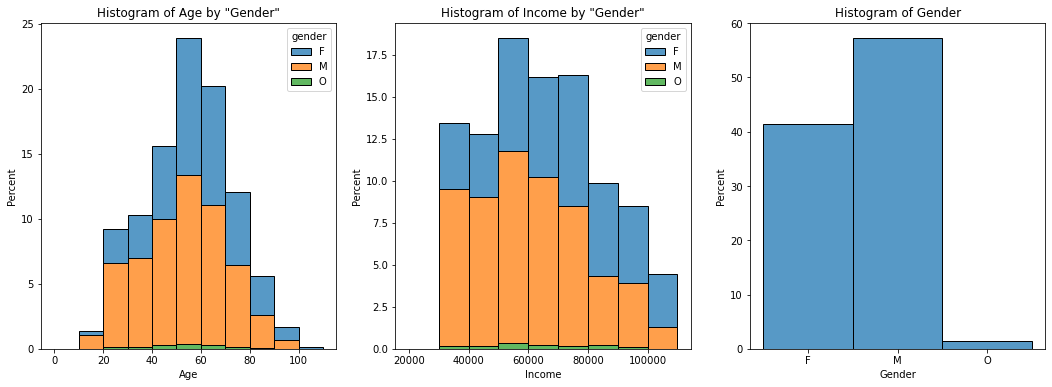

In [14]:
### Visualize ###
## plot the histogram of age , income
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6))
sns.histplot(clean_profile, x = 'age', hue = 'gender', ax = ax1, multiple = 'stack', stat='percent' ,bins = range(0, 120, 10))
ax1.set_title('Histogram of Age by "Gender"')
ax1.set_xlabel('Age')

sns.histplot(clean_profile, x = 'income', hue = 'gender', ax = ax2, multiple = 'stack' ,stat='percent', bins = range(20000, 120000, 10000))
ax2.set_title('Histogram of Income by "Gender"')
ax2.set_xlabel('Income')

sns.histplot(clean_profile, x = 'gender',stat='percent', ax = ax3)
ax3.set_title('Histogram of Gender')
ax3.set_xlabel('Gender')
plt.show()

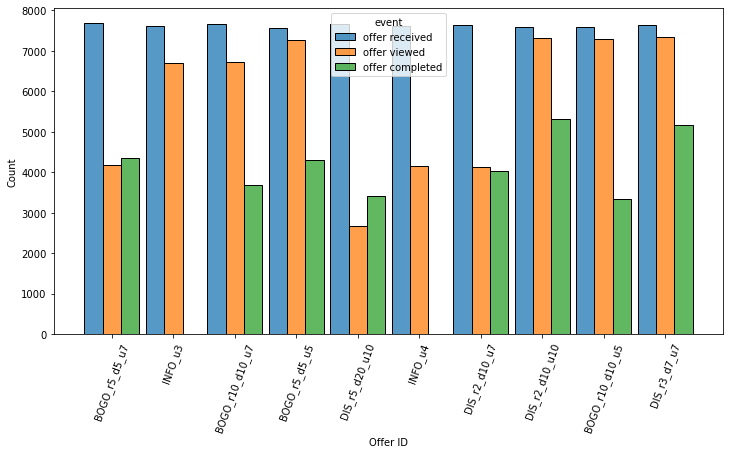

In [15]:
plt.figure(figsize=(12,6))
sns.histplot(elementary_trans[elementary_trans['event'].isin(['offer received', 'offer viewed', 'offer completed'])],
             x= 'offer_id', hue='event', multiple='dodge', shrink=0.9,
             hue_order=['offer received', 'offer viewed', 'offer completed'])
plt.xticks(rotation=70)
plt.xlabel('Offer ID')
plt.show()

The count of offer completed are even more than the count of offer viewed in some offers, we need to clean thease data.

In [18]:
def get_index_unusual(person_trans):
    offer_df = person_trans[['offer_id','duration']].dropna().drop_duplicates()
    vct_table = person_trans.reset_index()
    vct_table.fillna({'offer_id':'trans'}, inplace=True)
    vct_pivot = vct_table.pivot(index='index', columns=['offer_id', 'event'], values='time')
    offer_list = vct_pivot.columns.get_level_values(0).unique().tolist()
    bogo_dis = re.compile('^DIS|BOGO')
    offer_list = list(filter(bogo_dis.match, offer_list))

    unseq = []
    for offer in offer_list:
        viewed_offer = []
        df1 = vct_pivot[offer].dropna(how='all')
        #print(df1)
        for row in df1.index:
            try:
                if  pd.notnull(df1.loc[row,'offer received']):

                    val = df1.loc[row,'offer received'] + offer_df.loc[offer_df['offer_id'] == offer, 'duration'].values *24
                    #print(0)
                elif pd.notnull(df1.loc[row,'offer viewed']):
                    #print(viewed_offer)
                    viewed_offer.append(int(val[0]))
                    val = []
                    #print(1)

                elif len(viewed_offer) > 0:
                    # print(2)
                    while (len(viewed_offer) >0) and (df1.loc[row,'offer completed'] <= viewed_offer[0]):
                        viewed_offer.pop(0)
                        #print('pop one number')
                    
                    if len(viewed_offer) > 0:
                        viewed_offer.pop(0)
                    #else:
                     #   remain = df1.loc[row:,'offer completed']
                      #  unseq = unseq + remain[~remain.isnull()].tolist()                        
                else:
                    remain = df1.loc[row:,'offer completed']
                    unseq = unseq + remain[~remain.isnull()].tolist()
                    #print(3)
            except Exception:
                #print(repr(Exception))
                remain = df1.loc[row:,'offer completed']
                unseq = unseq + remain[~remain.isnull()].tolist()
    index_turn = person_trans[person_trans['time'].isin(unseq)].index
    return index_turn


In [20]:
def offer_get_rvc(data, duration):
    df = data.copy()
    received_only, viewed_only, completed = [],[],[]
    df.dropna(how='all', inplace=True)
    state = set(df.columns)
    if  state=={'offer received'}:
        received_only +=df.index.tolist()
    elif state=={'offer received', 'offer completed'}:
        received_only +=df['offer received'].dropna().index.tolist()
    elif state=={'offer received', 'offer viewed'}:
        # add deadline column
        df.loc[:, 'deadline'] = 24 * duration + df['offer received']

        # all offer recived time
        received_df = df['offer received'].dropna()
        # add offer received index as off_index
        df.loc[received_df.index, 'offer_index'] = received_df.index
        # all viewed time
        viewed_df = df['offer viewed'].dropna()
        
        received_latest = df.loc[received_df.index].loc[-viewed_df.shape[0]:]
        viewed_time_compare = received_latest[received_latest['deadline'].to_numpy() > df.loc[viewed_df.index, 'offer viewed'].to_numpy()].index

        df.loc[viewed_df.index, ['offer_index']] = viewed_time_compare
        print(df)
        received_only += received_df.index.drop(viewed_time_compare).tolist()
        viewed_only += viewed_time_compare.tolist()
    elif state=={'offer received', 'offer viewed', 'offer completed'}:
        # add deadline column
        df.loc[:, 'deadline'] = 24 * duration + df['offer received']

        # all offer recived time
        received_df = df['offer received'].dropna()
        # add offer received index as off_index
        df.loc[received_df.index, 'offer_index'] = received_df.index
        # all viewed time
        viewed_df = df['offer viewed'].dropna()
        
        received_latest = df.loc[received_df.index].loc[-viewed_df.shape[0]:]
        viewed_time_compare = received_latest[received_latest['deadline'].to_numpy() > df.loc[viewed_df.index, 'offer viewed'].to_numpy()].index


        completed_df = df['offer completed'].dropna()
        print(completed_df)
        completed_early = df.loc[completed_df.index].loc[-len(viewed_time_compare):]
        print(completed_early)

        completed_time_compare = completed_early[completed_early['deadline'].to_numpy() > df.loc[completed_df.index, 'offer completed'].to_numpy()].index
        #completed_time_compare
        print('*')
        print(completed_time_compare)
        print('*')
        print(df.loc[viewed_df.index, ['offer_index']])
        df.loc[viewed_df.index, ['offer_index']] = completed_time_compare
        print(df)
        received_only += received_df.index.drop(viewed_time_compare).tolist()
        viewed_only += viewed_time_compare.drop(completed_time_compare).tolist()

        completed += completed_time_compare.tolist()

    return received_only, viewed_only, completed


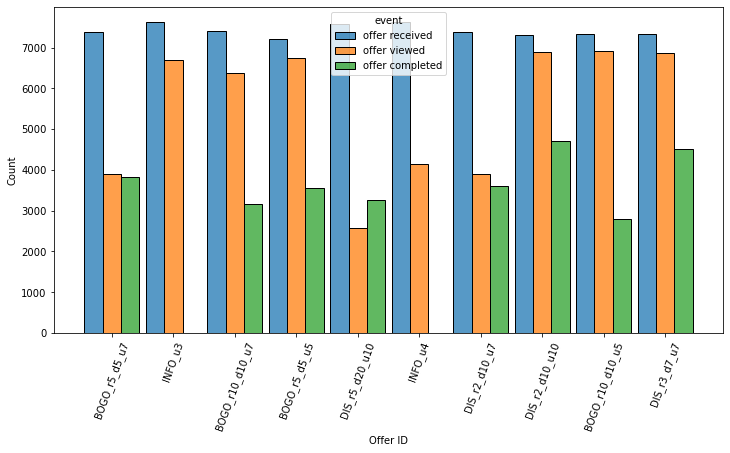

In [21]:
received_completed = elementary_trans[elementary_trans['event'].isin(['offer received', 'offer completed'])].groupby(['person_id','offer_id','time'])['event'].nunique()
received_completed = received_completed[received_completed > 1].reset_index()
received_completed_ = received_completed['offer_id'].astype(str) + '_' + received_completed['person_id'].astype(str) +  '_' + received_completed['time'].astype(str)
received_completed_

vieweded_completed = elementary_trans[elementary_trans['event'].isin(['offer viewed', 'offer completed'])].groupby(['person_id','offer_id','time'])['event'].nunique()
vieweded_completed = vieweded_completed[vieweded_completed > 1].reset_index()
vieweded_completed_ = vieweded_completed['offer_id'].astype(str) + '_' +  vieweded_completed['person_id'].astype(str) +  '_' + vieweded_completed['time'].astype(str)
vieweded_completed_


elementary_trans['person_offer_time'] = elementary_trans['offer_id'].astype(str) + '_' + elementary_trans['person_id'].astype(str) + '_' +  elementary_trans['time'].astype(str)

elementary_trans_new = elementary_trans[~ elementary_trans['person_offer_time'].isin(received_completed_)]
elementary_trans_new = elementary_trans_new[~ elementary_trans_new['person_offer_time'].isin(received_completed_)]

elementary_trans_new = elementary_trans_new[~ elementary_trans_new['person_offer_time'].isin(vieweded_completed_)]
elementary_trans_new = elementary_trans_new[~ elementary_trans_new['person_offer_time'].isin(vieweded_completed_) ]
plt.figure(figsize=(12,6))
sns.histplot(elementary_trans_new[elementary_trans_new['event'].isin(['offer received', 'offer viewed', 'offer completed'])],
             x= 'offer_id', hue='event', multiple='dodge', shrink=0.9,
             hue_order=['offer received', 'offer viewed', 'offer completed'])
plt.xticks(rotation=70)
plt.xlabel('Offer ID')
plt.show()

In [22]:
p1 = elementary_trans_new[elementary_trans_new['person_id']==105].reset_index().pivot(index='index', columns=['offer_id','event'],values='time')
p1 = p1['DIS_r2_d10_u10']
p1


event,offer received,offer viewed,offer completed
index,,,
1422,0.0,NaN,NaN
1423,NaN,96.0,NaN
1424,168.0,NaN,NaN
1425,NaN,180.0,NaN
1426,NaN,NaN,NaN
1427,NaN,NaN,198.0
1428,NaN,NaN,198.0
1429,NaN,NaN,NaN
1430,NaN,NaN,NaN


In [23]:
def get_index_only(data, duration):
    #print(data)
    df = data.copy()
    received_only, viewed_only, completed = [],[],[]
    df.dropna(how='all', inplace=True)
    state = set(df.columns)
    if  state=={'offer received'}:
        received_only +=df.index.tolist()
    elif state=={'offer received', 'offer completed'}:
        #print('*')
        received_only +=df['offer received'].dropna().index.tolist()
    elif state=={'offer received', 'offer viewed'}:
        df.loc[:, 'deadline'] = 24 * duration + df['offer received']
        received_df = pd.DataFrame(columns=['deadline', 'offer_index'])
        viewed_df = pd.DataFrame(columns=['deadline', 'offer_index'])
        complete_df = pd.DataFrame(columns=['deadline', 'offer_index'])
        for row in df.index:
            if ~np.isnan(df.loc[row, 'offer received']):
                received_df = received_df.append(pd.DataFrame({'deadline': df.loc[row, 'deadline'], 'offer_index': [row]}), ignore_index=True)
            elif (~np.isnan(df.loc[row, 'offer viewed'])) and (received_df.shape[0] > 0):
                while df.loc[row, 'offer viewed'] > received_df.loc[0, 'deadline'] and (received_df.shape[0] > 0):
                    received_only += received_df.loc[0, 'offer_index']
                    received_df.drop(0, inplace=True)
                    if received_df.shape[0] >0:
                        received_df.reset_index(drop=True, inplace=True)
                if received_df.shape[0] > 0:
                    df.loc[row, ['deadline', 'offer_index']] = received_df.loc[0]
                    viewed_df = viewed_df.append(pd.DataFrame({'deadline':df.loc[row, 'deadline'], 'offer_index':[row]}), ignore_index=True)
                    received_df.drop(0, inplace=True)
                    if received_df.shape[0] >0:
                        received_df.reset_index(drop=True, inplace=True)

        received_only += received_df.loc[:,'offer_index'].astype(int).tolist()
        viewed_only += viewed_df.loc[:, 'offer_index'].astype(int).tolist()
    elif state=={'offer received', 'offer viewed', 'offer completed'}:
        df.loc[:, 'deadline'] = 24 * duration + df['offer received']
        received_df = pd.DataFrame(columns=['deadline', 'offer_index'])
        viewed_df = pd.DataFrame(columns=['deadline', 'offer_index'])
        complete_df = pd.DataFrame(columns=['deadline', 'offer_index'])
        for row in df.index:
            if ~np.isnan(df.loc[row, 'offer received']):
                received_df = received_df.append(pd.DataFrame({'deadline': df.loc[row, 'deadline'], 'offer_index': [row]}), ignore_index=True)
            elif (~np.isnan(df.loc[row, 'offer viewed'])) & (received_df.shape[0] > 0):
                while (df.loc[row, 'offer viewed'] > received_df.loc[0 ,'deadline']) and (received_df.shape[0] > 0):
                    received_only  =  received_only + [received_df.loc[0, 'offer_index']]
                    
                    received_df.drop(0, inplace=True)
                    if received_df.shape[0] >0:
                        received_df.reset_index(drop=True, inplace=True)

                if received_df.shape[0] > 0:
                    df.loc[row, ['deadline', 'offer_index']] = received_df.loc[0]
                    viewed_df = viewed_df.append(pd.DataFrame({'deadline': df.loc[row, 'deadline'], 'offer_index': [row]}), ignore_index=True)
                    received_df.drop(0, inplace=True)
                    if received_df.shape[0] >0:
                        received_df.reset_index(drop=True, inplace=True)
            elif (~np.isnan(df.loc[row, 'offer completed'])) & (viewed_df.shape[0] > 0):
                while (df.loc[row, 'offer viewed'] > viewed_df.iloc[0]['deadline']) and (viewed_df.shape[0] > 0):
                    viewed_only += viewed_df.loc[0]['offer_index']
                    viewed_df.drop(0, inplace=True)
                    if viewed_df.shape[0]>0:
                        viewed_df.reset_index(drop=True, inplace=True)
                if viewed_df.shape[0] > 0:
                    #print(viewed_df)
                    df.loc[row, ['deadline', 'offer_index']] = viewed_df.loc[0]
                    complete_df = complete_df.append(pd.DataFrame({'deadline':df.loc[row, 'deadline'], 'offer_index':[row]}), ignore_index=True)
                    viewed_df.drop(0, inplace=True)
                    if viewed_df.shape[0]>0:
                        viewed_df.reset_index(drop=True, inplace=True)
        #print(df)
        
        #print(complete_df)
        received_only += received_df.loc[:,'offer_index'].astype(int).tolist()
        viewed_only += viewed_df.loc[:, 'offer_index'].astype(int).tolist()
        completed += complete_df.loc[:, 'offer_index'].astype(int).tolist()
    return received_only, viewed_only, completed

            


        

In [24]:
def get_index_forperson(person_trans):
    offer_df = person_trans[['offer_id','duration']].dropna().drop_duplicates()
    offer_df = offer_df.set_index('offer_id')
    vct_table = person_trans.reset_index()
    received, viewed , completed = [],[],[]

    vct_table.fillna({'offer_id':'trans'}, inplace=True)
    vct_pivot = vct_table.pivot(index='index', columns=['offer_id', 'event'], values='time')
    offer_list = vct_pivot.columns.get_level_values(0).unique().tolist()
    bogo_dis = re.compile('^DIS|BOGO')
    offer_list = list(filter(bogo_dis.match, offer_list))
    received_only, viewed_only , completed_only = [],[],[]

    for offer in offer_list:
#        try:
        received, viewed, completed = get_index_only(vct_pivot[offer], duration =offer_df.loc[offer])
#        except:
 #           print(offer)
        received_only += received
        viewed_only += viewed
        completed_only += completed

    return received_only, viewed_only, completed_only
get_index_forperson(elementary_trans_new[elementary_trans_new['person_id'] == 3746])



([], [166, 172, 180], [])

In [25]:
elementary_trans_new.head()

,event,time,person_id,amount,reward,offer_id,offer_reward,difficulty,duration,offer_type,channel_email,channel_mobile,channel_social,channel_web,person_offer_time
0,offer received,0,3,NaN,NaN,BOGO_r5_d5_u7,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0,BOGO_r5_d5_u7_3_0
1,offer viewed,6,3,NaN,NaN,BOGO_r5_d5_u7,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0,BOGO_r5_d5_u7_3_6
2,transaction,132,3,19.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan_3_132
3,offer completed,132,3,NaN,5.0,BOGO_r5_d5_u7,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0,BOGO_r5_d5_u7_3_132
4,transaction,144,3,17.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan_3_144


In [109]:
def clean_trans_logical(df):
    received_only, viewed_only , completed_only = [],[],[]
    received, viewed , completed = [],[],[]
    i = 0
    all = []
    person_list = df['person_id'].unique()
    for person in person_list:
        i+=1
        if (i % 500 ==0):
            print(print ('cleaning {:.2f}%'.format(i/len(person_list)*100), end="\r"))

        received, viewed, completed = get_index_forperson(df[df['person_id']==person])


        received_only += received
        viewed_only += viewed
        completed_only += completed
        
    all = received_only + viewed_only + completed_only

    
    return all
only_list = clean_trans_logical(elementary_trans_new)
%store only_list


Nonening 2.94%
Nonening 5.88%
Nonening 8.82%
Nonening 11.76%
Nonening 14.71%
Nonening 17.65%
Nonening 20.59%
Nonening 23.53%
Nonening 26.47%
Nonening 29.41%
Nonening 32.35%
Nonening 35.29%
Nonening 38.24%
Nonening 41.18%
Nonening 44.12%
Nonening 47.06%
Nonening 50.00%
Nonening 52.94%
Nonening 55.88%
Nonening 58.82%
Nonening 61.76%
Nonening 64.71%
Nonening 67.65%
Nonening 70.59%
Nonening 73.53%
Nonening 76.47%
Nonening 79.41%
Nonening 82.35%
Nonening 85.29%
Nonening 88.24%
Nonening 91.18%
Nonening 94.12%
Nonening 97.06%
Nonening 100.00%
Stored 'only_list' (list)


In [151]:
elementary_trans.head()


,event,time,person_id,amount,reward,offer_id,offer_reward,difficulty,duration,offer_type,channel_email,channel_mobile,channel_social,channel_web,person_offer_time
0,offer received,0,3,NaN,NaN,BOGO_r5_d5_u7,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0,BOGO_r5_d5_u7_3_0
1,offer viewed,6,3,NaN,NaN,BOGO_r5_d5_u7,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0,BOGO_r5_d5_u7_3_6
2,transaction,132,3,19.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan_3_132
3,offer completed,132,3,NaN,5.0,BOGO_r5_d5_u7,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0,BOGO_r5_d5_u7_3_132
4,transaction,144,3,17.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan_3_144


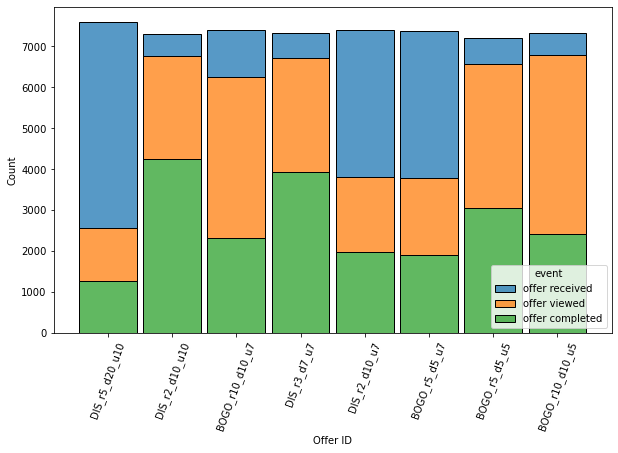

In [192]:
trans_new = elementary_trans_new.loc[only_list]
trans_new.shape
plt.figure(figsize=(10,6))
sns.histplot(trans_new[trans_new['event'].isin(['offer received', 'offer viewed', 'offer completed'])],
             x= 'offer_id', hue='event',multiple='stack',shrink=0.9,
             hue_order=['offer received', 'offer viewed', 'offer completed'])
plt.xticks(rotation=70)
plt.xlabel('Offer ID')
plt.show()

In [168]:
trans_new.head()

,event,time,person_id,amount,reward,offer_id,offer_reward,difficulty,duration,offer_type,channel_email,channel_mobile,channel_social,channel_web,person_offer_time
26,offer received,576,4,NaN,NaN,DIS_r5_d20_u10,5.0,20.0,10.0,discount,1.0,0.0,0.0,1.0,DIS_r5_d20_u10_4_576
36,offer received,504,5,NaN,NaN,DIS_r2_d10_u10,2.0,10.0,10.0,discount,1.0,1.0,1.0,1.0,DIS_r2_d10_u10_5_504
53,offer received,168,7,NaN,NaN,BOGO_r10_d10_u7,10.0,10.0,7.0,bogo,1.0,1.0,1.0,0.0,BOGO_r10_d10_u7_7_168
92,offer received,576,10,NaN,NaN,BOGO_r10_d10_u7,10.0,10.0,7.0,bogo,1.0,1.0,1.0,0.0,BOGO_r10_d10_u7_10_576
139,offer received,408,15,NaN,NaN,DIS_r3_d7_u7,3.0,7.0,7.0,discount,1.0,1.0,1.0,1.0,DIS_r3_d7_u7_15_408


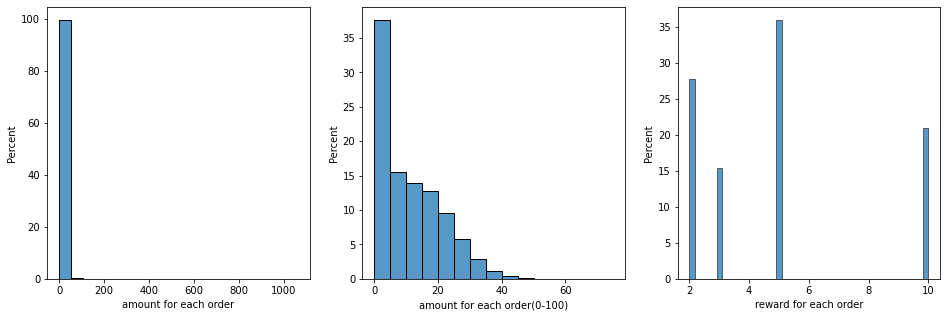

In [170]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16,5))

sns.histplot(elementary_trans, x = 'amount', stat='percent', ax = ax0, bins = 20)
ax0.set_xlabel('amount for each order')


sns.histplot(elementary_trans, x = 'amount', stat='percent', ax = ax1, bins = range(0, 80, 5))
ax1.set_xlabel('amount for each order(0-100)')
sns.histplot(elementary_trans, x = 'reward', stat='percent', ax = ax2)
ax2.set_xlabel('reward for each order')
plt.show()



### 3.2 Anaylize 


The most important information is how the comsumers responed to offers. So we will dig deeper in "transaction" 

As we want to find out the influence of offers, 
The offers which have the same viewed time and completed time, do not reflect how the customers react to offers.
we will remove these from data.

Add columns for NaN value

In [199]:
trans_without_offer = elementary_trans[elementary_trans['event'].isin(['transaction', 'offer completed'])].drop_duplicates(['person_id', 'time'])
trans_mean_std_count_without_offer = trans_without_offer.pivot_table(index='person_id', values='amount', aggfunc=('mean', 'std', 'count'))
trans_mean_std_count_without_offer

,count,mean,std
person_id,,,
0,9,2.266667,2.134315
1,3,25.670000,5.787927
2,6,2.383333,1.129295
3,7,22.752857,4.241013
4,3,1.550000,1.765531
...,...,...,...
16995,7,2.861429,0.898952
16996,7,3.710000,1.486495
16997,8,4.967500,2.479094


In [200]:
clean_profile

,gender,age,became_member_on,income,person_id
0,None,NaN,2017-02-12,NaN,0
1,F,55.0,2017-07-15,112000.0,1
2,None,NaN,2018-07-12,NaN,2
3,F,75.0,2017-05-09,100000.0,3
4,None,NaN,2017-08-04,NaN,4
...,...,...,...,...,...
16995,F,45.0,2018-06-04,54000.0,16995
16996,M,61.0,2018-07-13,72000.0,16996
16997,M,49.0,2017-01-26,73000.0,16997
16998,F,83.0,2016-03-07,50000.0,16998


# Section 3: Data Preparation

In [215]:
df = trans_new.merge(trans_mean_std_count_without_offer, on='person_id', how='left')
df = df.merge(clean_profile, on='person_id', how='left')
df['income_na'] = df['income'].apply(lambda x: 1 if np.isnan(x) else 0)
df['age_na'] = df['age'].apply(lambda x: 1 if np.isnan(x) else 0)
df['mean_na'] = df['mean'].apply(lambda x: 1 if np.isnan(x) else 0)
df['std_na'] = df['std'].apply(lambda x: 1 if np.isnan(x) else 0)
df['count_na'] = df['count'].apply(lambda x: 1 if np.isnan(x) else 0)

df['income'].fillna(df['income'].mean(), inplace=True)
df['age'].fillna(df['age'].mean(), inplace=True)
df['mean'].fillna(df['mean'].mean(), inplace=True)
df['std'].fillna(df['std'].mean(), inplace=True)
df['count'].fillna(df['count'].mean(), inplace=True)

df['gender'].fillna('none', inplace=True)
df['member_days'] = (df['became_member_on'].max() - df['became_member_on']).dt.days + 30
df.drop(['amount', 'reward', 'person_offer_time'],axis = 1,  inplace=True)
%store df
df.head()


Stored 'df' (DataFrame)


,event,time,person_id,offer_id,offer_reward,difficulty,duration,offer_type,channel_email,channel_mobile,...,gender,age,became_member_on,income,income_na,age_na,mean_na,std_na,count_na,member_days
0,offer received,576,4,DIS_r5_d20_u10,5.0,20.0,10.0,discount,1.0,0.0,...,none,54.232522,2017-08-04,65104.416885,1,1,0,0,0,386
1,offer received,504,5,DIS_r2_d10_u10,2.0,10.0,10.0,discount,1.0,1.0,...,M,68.000000,2018-04-26,70000.000000,0,0,0,0,0,121
2,offer received,168,7,BOGO_r10_d10_u7,10.0,10.0,7.0,bogo,1.0,1.0,...,none,54.232522,2017-10-02,65104.416885,1,1,0,0,0,327
3,offer received,576,10,BOGO_r10_d10_u7,10.0,10.0,7.0,bogo,1.0,1.0,...,none,54.232522,2017-08-24,65104.416885,1,1,0,0,0,366
4,offer received,408,15,DIS_r3_d7_u7,3.0,7.0,7.0,discount,1.0,1.0,...,F,62.000000,2016-02-11,71000.000000,0,0,0,0,0,926


In [216]:
df.columns

Index(['event', 'time', 'person_id', 'offer_id', 'offer_reward', 'difficulty',
       'duration', 'offer_type', 'channel_email', 'channel_mobile',
       'channel_social', 'channel_web', 'count', 'mean', 'std', 'gender',
       'age', 'became_member_on', 'income', 'income_na', 'age_na', 'mean_na',
       'std_na', 'count_na', 'member_days'],
      dtype='object')

### 1. Select x y values

In [217]:
x = df.drop(columns=['event', 'time', 'person_id','became_member_on'])
y = df['event'].apply(lambda x: 0 if x=='offer received' else( 1 if x=='offer viewed' else 2))
cate_features = ['offer_id', 'gender', 'offer_type']
for cate in cate_features:
    x = pd.concat([x.drop(columns=cate, axis=1), pd.get_dummies(x[cate], prefix=cate, prefix_sep='_')], axis=1)

stdscaler = StandardScaler()
MMscaler = MinMaxScaler()
numeric_features = ['mean', 'std','age', 'income']
MinMax_features = ['offer_reward', 'difficulty', 'duration', 'member_days','count']
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, stratify=y, random_state=42)

x_train[numeric_features] = stdscaler.fit_transform(x_train[numeric_features])
x_test[numeric_features] = stdscaler.transform(x_test[numeric_features])

x_train[MinMax_features] = MMscaler.fit_transform(x_train[MinMax_features])
x_test[MinMax_features] = MMscaler.transform(x_test[MinMax_features])



In [283]:
stdscaler.transform(x_test[numeric_features])

array([[-0.87304952, -0.30851699, -3.35906617, -3.23042555],
       [-0.87212006, -0.30692023, -3.27154409, -3.23042555],
       [-0.80956928, -0.30025387, -3.23729632, -3.23033181],
       ...,
       [-0.93049995, -0.3027814 , -3.34676543, -3.23041543],
       [-0.88212626, -0.30588779, -3.39711925, -3.23046502],
       [-0.91687416, -0.308626  , -3.48083602, -3.23041568]])

In [286]:
stdscaler.get_params()

{'copy': True, 'with_mean': True, 'with_std': True}

[296756.0121151375, 248221.8645637601, 201022.9245183801, 178045.39628999104, 164010.48768043614, 152121.78799427536, 142151.7842335296, 134771.79236193447, 128582.63372284135, 123870.33707235666, 118471.78262209827, 115504.21187546146, 110134.1696175638, 106600.85027962607, 104065.12471375657, 100314.60170456425, 97657.82137231469, 94456.7067213168, 91731.67893038831]


<AxesSubplot:>

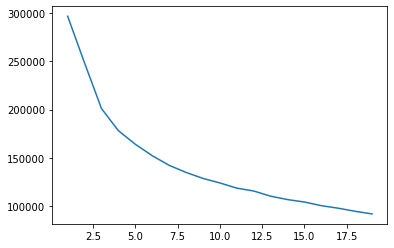

In [219]:
from sklearn.cluster import KMeans
number_cluster=[]
for ncluster in range(1,20):
    km = KMeans(n_clusters=ncluster, random_state=42)
    km.fit(x_train)
    number_cluster.append(km.inertia_)
    
print(number_cluster)
sns.lineplot(x=range(1,20), y=number_cluster)

#df.head()

# Secsion 4:Modeling

In [220]:
from sklearn.compose import ColumnTransformer
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, roc_curve,RocCurveDisplay, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelBinarizer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

In [221]:

models = {
    'K-Nearest Neighbors':KNeighborsClassifier(),
    'Decision Tree':DecisionTreeClassifier(random_state=42),
    'Random Forest':RandomForestClassifier(random_state=42),
    'Multi-layer Perceptron classifier':MLPClassifier(max_iter=500, random_state=42),
    'LightGBM':LGBMClassifier(random_state=42),
    'XGBoost':XGBClassifier(random_state=42)
}
model_name, score = [],[]
for name, model in models.items():
    clf = model
    split = StratifiedShuffleSplit(n_splits=4)
    mean_score = cross_val_score(clf,x_train,y_train,cv=split,scoring='roc_auc_ovr',n_jobs=-1, error_score='raise').mean()
    model_name.append(name)
    score.append(mean_score)

model_score = pd.DataFrame({'Classifier':model_name, 'Model score':score})
%store model_score
model_score

Stored 'model_score' (DataFrame)


,Classifier,Model score
0,K-Nearest Neighbors,0.788536
1,Decision Tree,0.684422
2,Random Forest,0.817804
3,Multi-layer Perceptron classifier,0.843913
4,LightGBM,0.848110
5,XGBoost,0.839498


LightGBM perform the best without hyperparameter tunning.

# Hyperparameter Tunning

In [222]:
from hyperopt import fmin, tpe, Trials, hp, STATUS_OK

In [236]:
space = {
    'boosting_type' : hp.choice('boosting_type', ['gbdt', 'dart']),
    'max_bin' : hp.choice('max_bin', range(200, 400, 20)),
    'max_depth' : hp.choice('max_depth', range(3, 20, 1)),
    'reg_alpha': hp.quniform('reg_alpha', 0, 60, 10),
    'reg_lambda': hp.uniform('reg_lambda', 0, 5),
    'n_estimators': hp.choice('n_estimators',range(100, 500, 50)),
    'learning_rate' : hp.uniform('learning_rate', 0.01, 2),

}

def objective(space):
    clf = LGBMClassifier(
        boosting_type=space['boosting_type'],
        max_bin=space['max_bin'],
        max_depth=space['max_depth'],
        reg_alpha=space['reg_alpha'],
        reg_lambda=space['reg_lambda'],
        n_estimators=space['n_estimators'],
        learning_rate=space['learning_rate']
    )

    split = StratifiedShuffleSplit(n_splits=4)


    score = cross_val_score(clf,x_train,y_train, cv=split, \
        scoring='roc_auc_ovr', error_score='raise').mean()


    loss = 1 - score

    return {'loss':loss,'status':STATUS_OK}  
trials = Trials()

best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, 
            trials=trials, verbose=2) 

100%|██████████| 50/50 [38:32<00:00, 46.25s/trial, best loss: 0.14769385042064354] 


In [237]:
best

{'boosting_type': 1,
 'learning_rate': 0.19906721840161523,
 'max_bin': 9,
 'max_depth': 6,
 'n_estimators': 6,
 'reg_alpha': 50.0,
 'reg_lambda': 2.814524696460551}

              precision    recall  f1-score   support

           0       0.64      0.60      0.62      4725
           1       0.73      0.68      0.70      6623
           2       0.63      0.72      0.67      6333

    accuracy                           0.67     17681
   macro avg       0.67      0.66      0.66     17681
weighted avg       0.67      0.67      0.67     17681



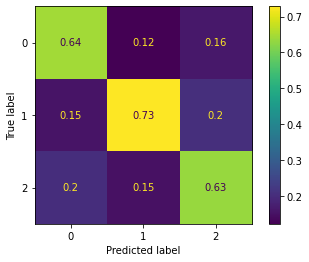

In [240]:
parameters = {'boosting_type': 'gbdt',
 'learning_rate': 0.19906721840161523,
 'max_bin': 9,
 'max_depth': 6,
 'n_estimators': 6,
 'reg_alpha': 50.0,
 'reg_lambda': 2.814524696460551}

clf = LGBMClassifier(**parameters, random_state=42)
clf.fit(x_train, y_train)
print(classification_report(y_test,clf.predict(x_test)))
ConfusionMatrixDisplay.from_estimator( clf, x_test, y_test, normalize = 'pred')
plt.show()

In [264]:
x_test.columns

Index(['offer_reward', 'difficulty', 'duration', 'channel_email',
       'channel_mobile', 'channel_social', 'channel_web', 'count', 'mean',
       'std', 'age', 'income', 'income_na', 'age_na', 'mean_na', 'std_na',
       'count_na', 'member_days', 'offer_id_BOGO_r10_d10_u5',
       'offer_id_BOGO_r10_d10_u7', 'offer_id_BOGO_r5_d5_u5',
       'offer_id_BOGO_r5_d5_u7', 'offer_id_DIS_r2_d10_u10',
       'offer_id_DIS_r2_d10_u7', 'offer_id_DIS_r3_d7_u7',
       'offer_id_DIS_r5_d20_u10', 'gender_F', 'gender_M', 'gender_O',
       'gender_none', 'offer_type_bogo', 'offer_type_discount'],
      dtype='object')

In [263]:
offer_info_re = re.compile('^offer|channel|difficulty|duration')
offer_list = list(filter(offer_info_re.match, x.columns))

offer_info = x[offer_list].drop_duplicates().reset_index(drop=True)
user_info = pd.DataFrame(columns=x.columns)
user_info[offer_list] = offer_info
user_info


,offer_reward,difficulty,duration,channel_email,channel_mobile,channel_social,channel_web,count,mean,std,...,offer_id_DIS_r2_d10_u10,offer_id_DIS_r2_d10_u7,offer_id_DIS_r3_d7_u7,offer_id_DIS_r5_d20_u10,gender_F,gender_M,gender_O,gender_none,offer_type_bogo,offer_type_discount
0,5.0,20.0,10.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,...,0,0,0,1,NaN,NaN,NaN,NaN,0,1
1,2.0,10.0,10.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,...,1,0,0,0,NaN,NaN,NaN,NaN,0,1
2,10.0,10.0,7.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN,...,0,0,0,0,NaN,NaN,NaN,NaN,1,0
3,3.0,7.0,7.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,...,0,0,1,0,NaN,NaN,NaN,NaN,0,1
4,2.0,10.0,7.0,1.0,1.0,0.0,1.0,NaN,NaN,NaN,...,0,1,0,0,NaN,NaN,NaN,NaN,0,1
5,5.0,5.0,7.0,1.0,1.0,0.0,1.0,NaN,NaN,NaN,...,0,0,0,0,NaN,NaN,NaN,NaN,1,0
6,5.0,5.0,5.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,...,0,0,0,0,NaN,NaN,NaN,NaN,1,0
7,10.0,10.0,5.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,...,0,0,0,0,NaN,NaN,NaN,NaN,1,0


In [296]:
clf.predict_proba(x_test.head(1))

array([[0.46340575, 0.22449424, 0.31210001]])

In [329]:
def recomand_offer(age, income, gender, count, mean, std, member_days, user_info=user_info,\
     classifier=clf,stdscaler=stdscaler, MMscaler=MMscaler):
    """
    recommand offer base on user infomation
    the result is base on the probality of completed the offer
    """
    user = user_info.copy()

    numeric_features = ['mean', 'std','age', 'income']
    MinMax_features = ['offer_reward', 'difficulty', 'duration', 'member_days','count']


    # process the input data
    user.loc[:,'age'] = 0 if np.isnan(age) else age
    user.loc[:,'age_na'] = 1 if np.isnan(age) else 0
    user.loc[:,'income'] = 0 if np.isnan(income) else income
    user.loc[:,'income_na'] = 1 if np.isnan(income) else 0

    user.loc[:,'count'] = 0 if np.isnan(count) else count
    user.loc[:,'count_na'] = 1 if np.isnan(count) else 0
    user.loc[:,'mean'] = 0 if np.isnan(mean) else mean
    user.loc[:,'mean_na'] = 1 if np.isnan(mean) else 0
    user.loc[:,'std'] = 0 if np.isnan(std) else std
    user.loc[:,'std_na'] = 1 if np.isnan(std) else 0
    user.loc[:,'member_days'] = 0 if np.isnan(member_days) else member_days

    user.loc[:,'gender_F'] = 0 if np.isnan(gender) else (1 if gender =='F' else 0)
    user.loc[:,'gender_M'] = 0 if np.isnan(gender) else (1 if gender =='M' else 0)
    user.loc[:,'gender_O'] = 0 if np.isnan(gender) else (1 if gender =='O' else 0)
    user.loc[:,'gender_none'] = 1 if np.isnan(gender) else 0

    # use scalers to transform the input data
    user[numeric_features] = stdscaler.transform(user[numeric_features])
    user[MinMax_features] = MMscaler.transform(user[MinMax_features])
    pred = clf.predict_proba(user)
    
    result = pd.concat([user.loc[:,user.columns.str.contains('^offer_id')], \
        pd.Series(pred[:,2], name='pred_proba')], axis = 1)
    result.sort_values('pred_proba', ascending=False, inplace=True)
    offer_list = result.columns[result.columns.str.contains('^offer_id')]
    result.loc[:, 'recommand_offer'] = result.loc[:,offer_list].\
        apply(lambda x: offer_list[x ==1].to_list()[0], axis = 1)
    return result[['recommand_offer', 'pred_proba']]

# age,income,gender,count,mean, std, member_days 
recomand_offer(np.nan,2,3,4,5,6,3)

,recommand_offer,pred_proba
3,offer_id_DIS_r3_d7_u7,0.316495
1,offer_id_DIS_r2_d10_u10,0.301457
6,offer_id_BOGO_r5_d5_u5,0.200841
7,offer_id_BOGO_r10_d10_u5,0.153576
2,offer_id_BOGO_r10_d10_u7,0.151288
5,offer_id_BOGO_r5_d5_u7,0.139388
4,offer_id_DIS_r2_d10_u7,0.134790
0,offer_id_DIS_r5_d20_u10,0.119856
